In [1]:
from src.dataset_gen import make_dataset_h5
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
make_dataset_h5(
    out_path="Data/data_burgers_ref.h5",
    num_cases=256,
    N_fine=1000,
    T=0.5,
    mu_min=1e-3,
    mu_max=1e-1,
    save_stride=20,
    seed=0,
)


Generating cases: 100%|██████████| 256/256 [09:48<00:00,  2.30s/it]


In [ ]:
def inspect_dataset_layout_2x2_plus_heatmap(h5_path, case_idx=0, max_scatter=6000):
    h5_path = Path(h5_path)
    if not h5_path.exists():
        raise FileNotFoundError(f"Dataset not found: {h5_path}")

    with h5py.File(h5_path, "r") as f:
        cases = sorted(f["cases"].keys())
        if len(cases) == 0:
            raise ValueError("No cases found under group 'cases'.")

        case_idx = int(np.clip(case_idx, 0, len(cases) - 1))
        g = f["cases"][cases[case_idx]]

        x = g["x"][:]
        times = g["times"][:]
        U = g["U"][:]  # shape [Nt, N]
        mu = float(g.attrs["mu"])

        uL = g["uL"][:] if "uL" in g else None
        uR = g["uR"][:] if "uR" in g else None

    dx = float(x[1] - x[0])
    L = float(x.max() - x.min())

    # ----- Figure layout: 3 rows; (2,2,1 spanning) -----
    fig = plt.figure(figsize=(15, 11))

    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1.2])
    ax_heat = fig.add_subplot(gs[2, 1:3])  # middle half
    ax_snap  = fig.add_subplot(gs[0, 0])
    ax_mass  = fig.add_subplot(gs[0, 1])
    ax_scatt = fig.add_subplot(gs[1, 0])
    ax_jump  = fig.add_subplot(gs[1, 1])
    
    
    snap_ids = np.linspace(0, U.shape[0] - 1, 5, dtype=int)
    for k in snap_ids:
        ax_snap.plot(x, U[k], label=f"t={times[k]:.3f}")
    ax_snap.set_title("Solution snapshots")
    ax_snap.set_xlabel("x")
    ax_snap.set_ylabel("u")
    ax_snap.legend(fontsize=8)

   
    mass = U.mean(axis=1) * L
    ax_mass.plot(times, mass, lw=2)
    ax_mass.set_title("Mass vs time")
    ax_mass.set_xlabel("t")
    ax_mass.set_ylabel(r"$\int u\,dx$ (approx)")

    
    if uL is not None and uR is not None and uL.size > 0:
        n = min(max_scatter, uL.size)
        idx = np.random.choice(uL.size, size=n, replace=False)
        ax_scatt.scatter(uL[idx], uR[idx], s=6, alpha=0.25)

        # diagonal reference line using current limits after scatter
        lo = min(ax_scatt.get_xlim()[0], ax_scatt.get_ylim()[0])
        hi = max(ax_scatt.get_xlim()[1], ax_scatt.get_ylim()[1])
        ax_scatt.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1)

        ax_scatt.set_title("(uL, uR) scatter")
        ax_scatt.set_xlabel("uL")
        ax_scatt.set_ylabel("uR")
    else:
        ax_scatt.text(0.5, 0.5, "No interface data (uL/uR) found",
                      ha="center", va="center")
        ax_scatt.set_axis_off()

    
    if uL is not None and uR is not None and uL.size > 0:
        jump = uR - uL
        ax_jump.hist(jump, bins=120)
        ax_jump.set_title("Jump distribution (uR - uL)")
        ax_jump.set_xlabel("uR - uL")
        ax_jump.set_ylabel("count")
    else:
        ax_jump.text(0.5, 0.5, "No interface data (uL/uR) found",
                     ha="center", va="center")
        ax_jump.set_axis_off()

    
    im = ax_heat.imshow(
        U,
        aspect="auto",
        origin="lower",
        extent=[x.min(), x.max(), times.min(), times.max()],
    )
    ax_heat.set_title("Space–time heatmap")
    ax_heat.set_xlabel("x")
    ax_heat.set_ylabel("t")
    fig.colorbar(im, ax=ax_heat, fraction=0.025, pad=0.02, label="u")

    fig.suptitle(
        f"Viscous Burgers reference data inspection | case={case_idx} | "
        f"N={x.size} | Nt={U.shape[0]} | dx={dx:.3e} | mu={mu:.2e}",
        fontsize=14
    )

    fig.tight_layout()
    plt.show()



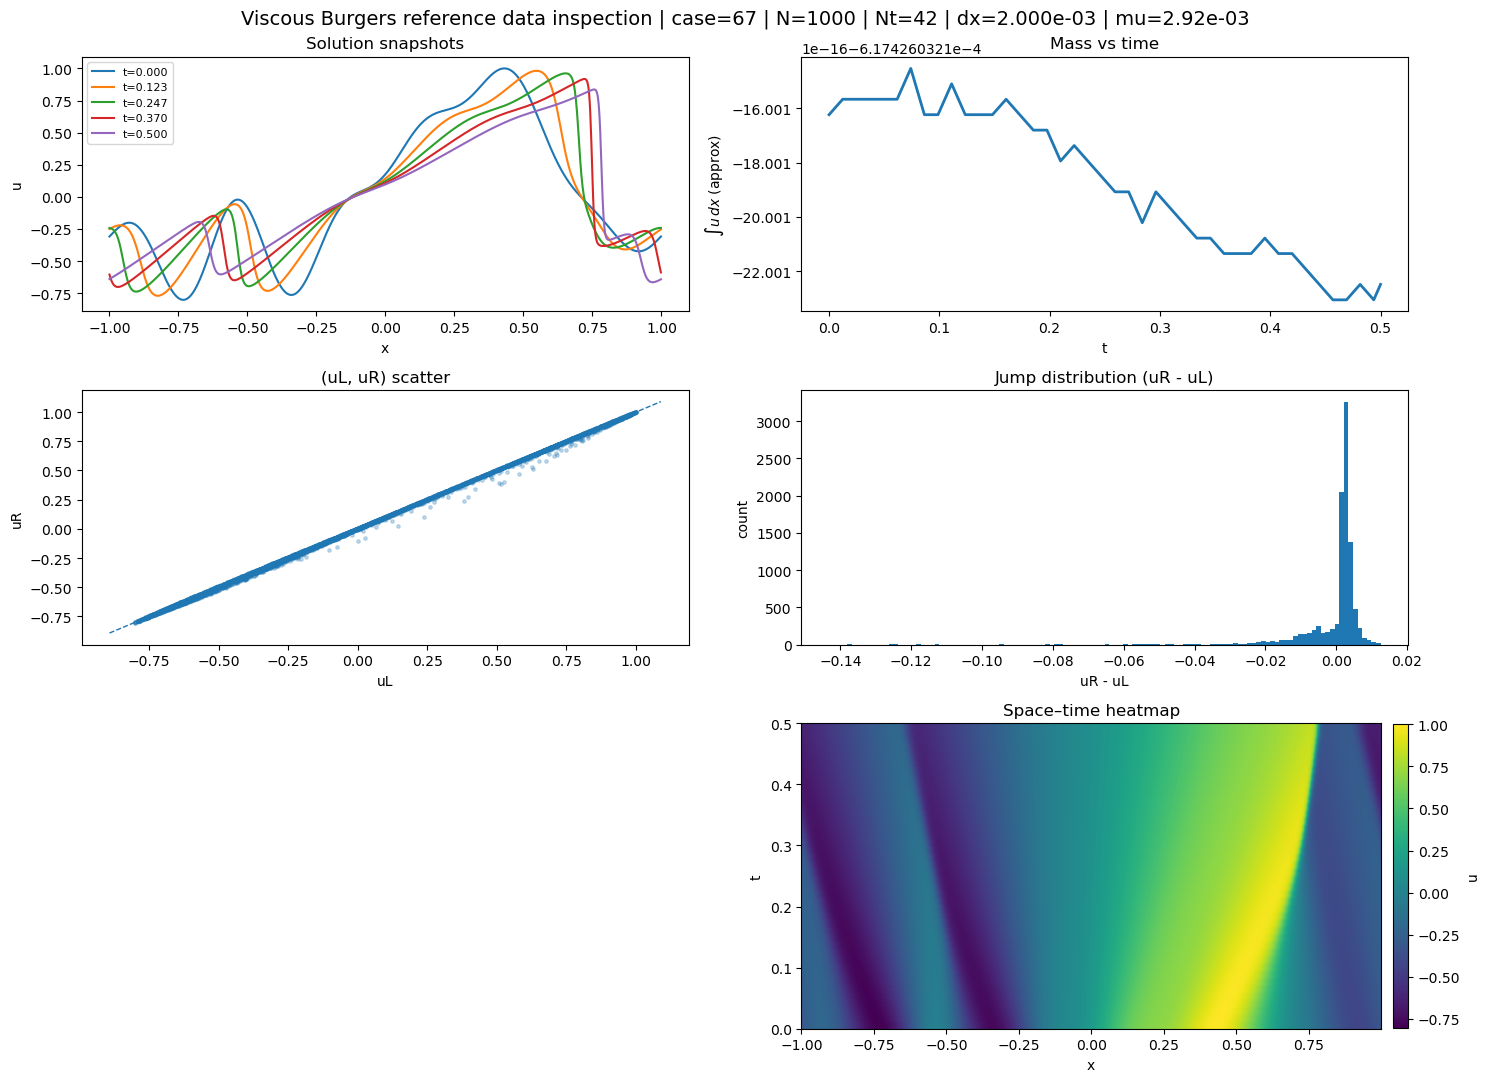

In [6]:
inspect_dataset_layout_2x2_plus_heatmap("Data/data_burgers_ref.h5", case_idx=67)